<a href="https://colab.research.google.com/github/pinellolab/crispr-bean/blob/main/docs/ReporterScreen_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRISPR Reporter Screen analysis with BEAN

In this tutorial, we will cover
*  Obtaining target variant editing rate from allele count information
*  ReporterScreen object slicing (indexing)
*  Allele filtering based on significance

For the basic API of ReporterScreen object, see [**perturb-tools tutorial of Screen API**](https://github.com/pinellolab/perturb-tools/blob/main/perturb_tools/screen_demo.ipynb).

In [ ]:
! pip install -q crispr-bean

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bean as be
import logging

logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
!wget https://github.com/pinellolab/crispr-bean/raw/main/tests/data/var_mini_screen.h5ad

--2024-06-10 17:08:18--  https://github.com/pinellolab/crispr-bean/raw/main/tests/data/var_mini_screen.h5ad
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pinellolab/crispr-bean/main/tests/data/var_mini_screen.h5ad [following]
--2024-06-10 17:08:18--  https://raw.githubusercontent.com/pinellolab/crispr-bean/main/tests/data/var_mini_screen.h5ad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1452304 (1.4M) [application/octet-stream]
Saving to: ‘var_mini_screen.h5ad.1’

var_mini_screen.h5a 100%[===================>]   1.38M  --.-KB/s    in 0.04s   

2024-06-10 17:08:19 (32.9 MB/s) - ‘var_mini_scr

In [ ]:
bdata = be.read_h5ad("var_mini_screen.h5ad")

## Data Structure

ReporterScreen object is a shallow wrapper around [AnnData](https://anndata.readthedocs.io/en/latest/). More comprehensive data wrangling documentation can be found in their documentation.

In [ ]:
bdata

Genome Editing Screen comprised of n_guides x n_conditions = 30 x 10
   guides:    'Unnamed: 0', 'Target gene/variant', 'Target descriptor', 'Arbitrary number', 'gRNA position category', 'Target base position in gRNA', 'Target base position in reporter', 'BE', 'target_group', 'sequence', 'reporter', 'barcode', '5-nt PAM', 'offset', 'target', 'target_pos', 'Group2', 'masked_sequence', 'masked_barcode', 'chrom', 'genomic_pos'
   samples:   'condition', 'replicate', 'lower_quantile', 'upper_quantile'
   samples_m: 
   samples_p: 
   layers:    'X_bcmatch', 'edits'
   uns:       'allele_counts', 'edit_counts', 'target_base_changes', 'tiling'

* `ReporterScreen.X`: guide count
* `ReporterScreen.guides`: guide metadata. Reference to `AnnData.obs`
* `ReporterScreen.samples`: sample/condition metadata. Reference to `AnnData.var`.
* `ReporterScreen.layers["X_bcmatch"]`: barcode-matched guide counts
* `ReporterScreen.layers["edits"]`: edit counts
* `ReporterScreen.uns["allele_counts"]`: allele counts per guide and condition
* `ReporterScreen.uns["edit_counts"]`: edit counts per guide and condition

`.guides` attribute contains the information about each guide.

In [ ]:
bdata.guides.head()

,Unnamed: 0,Target gene/variant,Target descriptor,Arbitrary number,gRNA position category,Target base position in gRNA,Target base position in reporter,BE,target_group,sequence,...,barcode,5-nt PAM,offset,target,target_pos,Group2,masked_sequence,masked_barcode,chrom,genomic_pos
name,,,,,,,,,,,,,,,,,,,,,
CONTROL_8_g1,90,CONTROL,NaN,8,g1,4,10,ABE,NegCtrl,AAAATTATCGGAAACGGTAG,...,GAAC,AATCT,-10,CONTROL_8,9,NegCtrl,GGGGTTGTCGGGGGCGGTGG,GGGC,NaN,NaN
CONTROL_8_g2,91,CONTROL,NaN,8,g2,5,11,ABE,NegCtrl,AAAAATTATCGGAAACGGTA,...,CGTG,GAATC,-11,CONTROL_8,10,NegCtrl,GGGGGTTGTCGGGGGCGGTG,CGTG,NaN,NaN
CONTROL_8_g3,92,CONTROL,NaN,8,g3,5,12,ABE,NegCtrl,AAAAATTATCGGAAACGGT,...,ATCA,AGAAT,-12,CONTROL_8,11,NegCtrl,GGGGGTTGTCGGGGGCGGT,GTCG,NaN,NaN
CONTROL_8_g4,93,CONTROL,NaN,8,g4,7,13,ABE,NegCtrl,CGAAAAATTATCGGAAACGG,...,CAAG,TAGAA,-13,CONTROL_8,12,NegCtrl,CGGGGGGTTGTCGGGGGCGG,CGGG,NaN,NaN
CONTROL_8_g5,94,CONTROL,NaN,8,g5,8,14,ABE,NegCtrl,TCGAAAAATTATCGGAAACG,...,TTCA,GTAGA,-14,CONTROL_8,13,NegCtrl,TCGGGGGGTTGTCGGGGGCG,TTCG,NaN,NaN


`.samples` attribute contains the sample and condition specific information.

In [ ]:
bdata.samples

,condition,replicate,lower_quantile,upper_quantile
rep5_top,top,rep5,0.8,1.0
rep5_high,high,rep5,0.6,0.8
rep5_bulk,bulk,rep5,0.0,1.0
rep5_low,low,rep5,0.2,0.4
rep5_bot,bot,rep5,0.0,0.2
rep6_top,top,rep6,0.8,1.0
rep6_high,high,rep6,0.6,0.8
rep6_bulk,bulk,rep6,0.0,1.0
rep6_low,low,rep6,0.2,0.4
rep6_bot,bot,rep6,0.0,0.2


Per-guide allele count information is stored in `.uns['allele_counts']`.

In [ ]:
bdata.uns["allele_counts"]

,guide,allele,rep5_top,rep5_high,rep5_bulk,rep5_low,rep5_bot,rep6_top,rep6_high,rep6_bulk,rep6_low,rep6_bot
0,ACAT2_SA_45_g4,1:12:+:A>T,0,0,0,0,0,0,0,0,0,0
1,ACAT2_SA_45_g4,12:23:+:A>G,2,19,26,13,2,40,203,43,210,67
2,ACAT2_SA_45_g4,1:12:+:A>G,30,21,23,73,6,6,18,0,1,4
3,ACAT2_SA_45_g4,14:25:+:A>G,4,1,0,0,0,0,0,0,0,0
4,ACAT2_SA_45_g4,"1:12:+:A>G,12:23:+:A>G,15:26:+:A>G",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4921,ACAT2_SA_47_g2,"1:10:+:A>G,6:15:+:A>G,18:27:+:A>T,20:29:+:A>G",0,0,0,0,1,0,0,0,0,0
4922,ACAT2_SA_47_g2,16:25:+:C>T,0,0,0,0,1,0,0,0,0,0
4923,ACAT2_SA_47_g1,"-8:0:+:T>-,7:15:+:A>G,8:16:+:A>G,9:17:+:A>G,14...",0,0,0,0,1,0,0,0,0,0
4924,ACAT2_SA_47_g1,"1:9:+:A>G,6:14:+:A>G,9:17:+:A>G,13:21:+:A>G,17...",0,0,0,0,1,0,0,0,0,0


Per-variant aggregated count information is stored in `.uns['edit_counts']`.

In [ ]:
bdata.uns["edit_counts"]

,guide,edit,rep5_top,rep5_high,rep5_bulk,rep5_low,rep5_bot,rep6_top,rep6_high,rep6_bulk,rep6_low,rep6_bot
0,ACAT2_SA_44_g1,-4:4:+:A>G,154,53,32,235,10,85,167,232,219,79
1,ACAT2_SA_44_g1,11:19:+:A>G,14,44,63,161,6,77,88,51,29,72
2,ACAT2_SA_44_g1,1:9:+:A>G,37,65,68,195,18,21,42,63,50,23
3,ACAT2_SA_44_g1,22:30:+:A>G,11,19,33,167,3,0,0,0,1,18
4,ACAT2_SA_44_g1,6:14:+:C>A,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1761,ACAT2_SA_46_g5,0:12:+:T>C,0,0,0,1,0,0,0,0,0,0
1762,ACAT2_SA_47_g2,-9:0:+:C>-,0,0,0,1,0,0,0,0,0,0
1763,ACAT2_SA_47_g2,22:31:+:->A,0,0,0,1,0,0,0,0,0,0
1764,CONTROL_8_g1,7:15:+:G>A,0,0,0,1,0,0,0,0,0,0


## Changing column names

`ReporterScreen.guides` and `ReporterScreen.var` are equivalent to `AnnData.obs` and `AnnData.var`, which are Pandas DataFrames and can be [manipulated as the DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). For example, column names can be changed as in Pandas:

In [ ]:
bdata.guides = bdata.guides.rename(columns={"Reporter":"reporter"})

## Subsetting & addition



Works as anndata, supports allele & edit count operations.


### Subsetting & selection


ReporterScreen can be subsetted for rows (guides) / selected for columns (samples) [as in AnnData](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html#Subsetting-AnnData).

In [ ]:
bdata_subset = bdata[:10,bdata.samples.condition == "bulk"]

In [ ]:
bdata_subset

Genome Editing Screen comprised of n_guides x n_conditions = 10 x 2
   guides:    'Unnamed: 0', 'Target gene/variant', 'Target descriptor', 'Arbitrary number', 'gRNA position category', 'Target base position in gRNA', 'Target base position in reporter', 'BE', 'target_group', 'sequence', 'reporter', 'barcode', '5-nt PAM', 'offset', 'target', 'target_pos', 'Group2', 'masked_sequence', 'masked_barcode', 'chrom', 'genomic_pos'
   samples:   'condition', 'replicate', 'lower_quantile', 'upper_quantile'
   samples_m: 
   samples_p: 
   layers:    'X_bcmatch', 'edits'
   uns:       'allele_counts', 'edit_counts', 'target_base_changes', 'tiling'

## Getting edit rates from allele counts



`ReporterScreen.uns["edit_counts"]` is derived from `ReporterScreen.uns["allele_counts"]`, then used to generated per-guide or per-window editing rate.

In [ ]:
bdata.uns['allele_counts']

,guide,allele,rep5_top,rep5_high,rep5_bulk,rep5_low,rep5_bot,rep6_top,rep6_high,rep6_bulk,rep6_low,rep6_bot
0,ACAT2_SA_45_g4,1:12:+:A>T,0,0,0,0,0,0,0,0,0,0
1,ACAT2_SA_45_g4,12:23:+:A>G,2,19,26,13,2,40,203,43,210,67
2,ACAT2_SA_45_g4,1:12:+:A>G,30,21,23,73,6,6,18,0,1,4
3,ACAT2_SA_45_g4,14:25:+:A>G,4,1,0,0,0,0,0,0,0,0
4,ACAT2_SA_45_g4,"1:12:+:A>G,12:23:+:A>G,15:26:+:A>G",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4921,ACAT2_SA_47_g2,"1:10:+:A>G,6:15:+:A>G,18:27:+:A>T,20:29:+:A>G",0,0,0,0,1,0,0,0,0,0
4922,ACAT2_SA_47_g2,16:25:+:C>T,0,0,0,0,1,0,0,0,0,0
4923,ACAT2_SA_47_g1,"-8:0:+:T>-,7:15:+:A>G,8:16:+:A>G,9:17:+:A>G,14...",0,0,0,0,1,0,0,0,0,0
4924,ACAT2_SA_47_g1,"1:9:+:A>G,6:14:+:A>G,9:17:+:A>G,13:21:+:A>G,17...",0,0,0,0,1,0,0,0,0,0


In [ ]:
bdata.get_edit_from_allele()

In [ ]:
bdata.uns["edit_counts"]

,guide,edit,rep5_top,rep5_high,rep5_bulk,rep5_low,rep5_bot,rep6_top,rep6_high,rep6_bulk,rep6_low,rep6_bot
0,ACAT2_SA_44_g1,-2:6:+:T>A,0,0,0,0,0,0,0,0,0,0
1,ACAT2_SA_44_g1,-2:6:+:T>C,0,0,0,0,0,0,0,0,0,0
2,ACAT2_SA_44_g1,-3:5:+:T>A,1,0,0,0,0,0,0,0,0,0
3,ACAT2_SA_44_g1,-3:5:+:T>C,0,0,0,0,0,0,0,0,1,0
4,ACAT2_SA_44_g1,-3:5:+:T>G,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1761,CONTROL_9_g5,7:19:+:A>T,0,0,0,0,0,0,1,0,0,0
1762,CONTROL_9_g5,8:20:+:C>A,0,0,0,0,0,0,0,0,0,0
1763,CONTROL_9_g5,8:20:+:C>T,0,0,0,0,0,0,1,0,0,0
1764,CONTROL_9_g5,9:21:+:C>-,0,0,0,0,0,0,0,0,0,0


In [ ]:
bdata.get_edit_mat_from_uns(target_pos_col = "target_pos")

New edit matrix saved in .layers['edits']. Returning old edits.


array([[1.900e+01, 2.500e+01, 6.200e+01, 8.400e+01, 7.000e+00, 1.500e+01,
        1.120e+02, 1.190e+02, 9.200e+01, 4.300e+01],
       [8.000e+00, 2.000e+00, 0.000e+00, 4.700e+01, 5.000e+00, 1.900e+01,
        2.410e+02, 1.800e+01, 3.100e+01, 4.800e+01],
       [3.700e+01, 2.000e+01, 3.500e+01, 6.300e+01, 1.000e+00, 2.470e+02,
        8.260e+02, 4.150e+02, 5.800e+02, 5.040e+02],
       [2.000e+00, 2.500e+01, 4.300e+01, 6.200e+01, 8.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [3.000e+00, 3.100e+01, 3.000e+01, 1.470e+02, 1.200e+01, 0.000e+00,
        6.000e+01, 1.100e+01, 4.000e+00, 2.000e+00],
       [1.700e+02, 8.200e+01, 7.400e+01, 2.080e+02, 1.000e+01, 2.140e+02,
        9.500e+02, 3.960e+02, 4.610e+02, 1.620e+02],
       [1.400e+01, 4.200e+01, 2.200e+01, 4.900e+01, 1.700e+01, 0.000e+00,
        7.000e+01, 0.000e+00, 0.000e+

In [ ]:
window_edit_rate= bdata.get_guide_edit_rate(normalize_by_editable_base = True,
                   editable_base_start = 3,
                   editable_base_end = 8,
                   bcmatch_thres = 5, # Ignore samples with X_bcmatch < 5 for stability
                   prior_weight = 1,
                   return_result = True)

normalize by editable counts


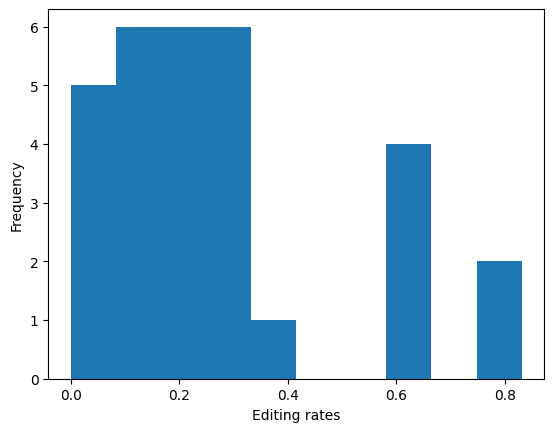

In [ ]:
plt.hist(window_edit_rate)
plt.xlabel("Editing rates")
plt.ylabel("Frequency")
plt.show()